## Efficient Frontier

**Joshua and Jingwen**

The Efficient Frontier represents the set of optimal portfolios offering the highest expected return for a given level of risk. It is derived by analyzing different portfolio combinations and plotting risk (measured by standard deviation) against expected return. Any portfolio below the frontier is suboptimal, as higher returns could be achieved for the same risk level.

### Initialization

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting

In [28]:
# Load S&P 500 prices
sp500_prices = pd \
    .read_csv("../data/raw/tessa_sp500_prices.csv") \
    .drop(columns=['GEV', 'SOLV', 'SW']) \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)
    
# Load NCI prices
nci_prices = pd \
    .read_csv("../data/raw/tessa_nci_prices.csv") \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)

# Left join on S&P
data = pd.merge(sp500_prices, nci_prices, on="date", how="left")

data

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,ZTS,ADA-USD,AVAX-USD,BTC-USD,ETH-USD,LINK-USD,LTC-USD,SOL-USD,UNI-USD,XRP-USD
date,,,,,,,,,,,,,,,,,,,,,
2024-03-15,146.463730,171.808746,171.628006,160.639999,113.183418,87.368553,370.019684,492.459991,192.012970,57.146446,...,170.748978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18,145.083298,172.903580,172.216553,161.860001,110.194344,86.912125,368.113281,513.859985,188.097961,58.206318,...,168.888824,0.661258,60.689945,67548.593750,3517.985107,18.324354,87.112206,195.992752,0.000217,0.647565
2024-03-19,146.374374,175.252502,173.345444,161.789993,110.899956,87.168869,373.457123,521.190002,187.429062,58.803699,...,171.134842,0.586914,53.525894,61912.773438,3157.618164,16.809296,78.586372,170.016281,0.000198,0.584441
2024-03-20,146.265106,177.830292,170.074600,164.710007,109.273117,87.701378,375.788269,519.140015,191.147369,59.073486,...,169.185654,0.639481,57.030720,67913.671875,3513.393066,18.406483,84.789017,191.549622,0.000217,0.612162
2024-03-21,147.715057,170.564621,171.261353,168.179993,109.282906,86.236992,340.811249,511.250000,191.963791,60.191174,...,166.543823,0.631868,53.865566,65491.390625,3492.991211,18.431383,85.701622,179.220749,0.000210,0.640691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,121.900002,227.479996,216.660004,132.149994,137.360001,90.720001,335.299988,435.079987,216.259995,50.610001,...,171.800003,0.672597,16.285971,78532.000000,1861.151367,12.693139,87.557991,118.291748,0.000158,2.018294
2025-03-11,121.029999,220.839996,213.589996,125.440002,132.660004,90.089996,327.790009,433.660004,209.080002,48.639999,...,164.389999,0.722587,17.474718,82862.210938,1919.844971,13.099883,90.332718,125.263947,0.000166,2.166916
2025-03-12,119.849998,216.979996,212.059998,126.550003,130.279999,89.160004,324.329987,438.600006,206.619995,47.080002,...,161.679993,0.735444,18.899162,83722.359375,1908.982666,13.482376,91.489655,126.583244,0.000168,2.240755


In [29]:
# Check for NA values in the DataFrame
na_check = data.isna().sum()
print("NA values in each column:\n", na_check[na_check > 0])

NA values in each column:
 ADA-USD     1
AVAX-USD    1
BTC-USD     1
ETH-USD     1
LINK-USD    1
LTC-USD     1
SOL-USD     1
UNI-USD     1
XRP-USD     1
dtype: int64


In [30]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()

In [31]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 86.8%
Annual volatility: 10.8%
Sharpe Ratio: 8.05


(np.float64(0.8676929924085912),
 np.float64(0.1077232742410989),
 np.float64(8.054833075966293))

In [32]:
mu[mu>0]

AAPL       0.245859
ABBV       0.237018
ABT        0.121034
ACGL       0.060273
ADI        0.088261
             ...   
YUM        0.157314
ADA-USD    0.118519
BTC-USD    0.247462
LTC-USD    0.049263
XRP-USD    2.715536
Length: 300, dtype: float64

c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Expected annual return: 272.9%
Annual volatility: 54.4%
Sharpe Ratio: 5.01
(np.float64(2.7291959770668126), np.float64(0.5444859667552959), np.float64(5.012426662399866))


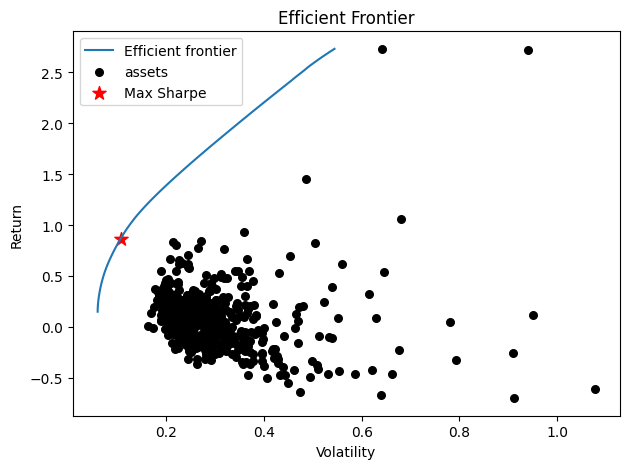

In [33]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S)

# Generate plot
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=4.31)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Log performance
print(ef.portfolio_performance(verbose=True))

# Output
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [23]:
weights = ef_max_sharpe.clean_weights()

{e[0]: e[1] for e in sorted(list(weights.items()), key=lambda x: -x[1]) if e[1] > 0}


{'K': 0.16763,
 'PM': 0.09563,
 'FOX': 0.07208,
 'T': 0.0685,
 'PLTR': 0.06244,
 'GILD': 0.06231,
 'WELL': 0.05721,
 'TPL': 0.04806,
 'FOXA': 0.04784,
 'ETR': 0.04697,
 'TMUS': 0.04683,
 'MMM': 0.03609,
 'TTWO': 0.03415,
 'XRP-USD': 0.0329,
 'MCK': 0.02819,
 'RTX': 0.02741,
 'MO': 0.01801,
 'VTR': 0.01578,
 'CBOE': 0.01023,
 'KDP': 0.00942,
 'AVGO': 0.00668,
 'NVDA': 0.00566}

In [22]:
mu
mu.sort_values()

AVAX-USD   -0.699809
MRNA       -0.671018
CE         -0.642312
SMCI       -0.609853
EL         -0.550066
              ...   
HWM         0.930633
VST         1.059809
TPL         1.450006
XRP-USD     2.715536
PLTR        2.729330
Length: 507, dtype: float64

Palantir's returns are crazy lmao